In [ ]:
"""
================================================================================
AILS vs MCPP Comparison - Using Exact Same Data as Lee & Lee (2025)
================================================================================

This notebook uses the EXACT same benchmark datasets from:
"Multi-Agent Coverage Path Planning Using Graph-Adapted K-Means in Road Network Digital Twin"
Lee & Lee, Electronics 2025, 14, 3921

DATA SOURCES:
=============

1. MOVING AI LAB MAPF BENCHMARKS (Grid Maps):
   Download from: https://www.movingai.com/benchmarks/mapf/index.html
   
   Maps used:
   - den312d.map (65x81, 2445 vertices) - Dragon Age game map
   - ht_chantry.map (162x141, 7461 vertices) - Game map
   - random-64-64-20.map (64x64, 3270 vertices) - 20% random obstacles

2. ROAD NETWORK DIGITAL TWINS (Non-Grid):
   These are custom datasets. Options to obtain:
   a) Contact authors: myungho.lee@pusan.ac.kr
   b) Extract from OpenStreetMap using OSMnx library
   
   Networks used:
   - pnu: Pusan National University campus (92 vertices, 112 edges)
   - jangjeon: Jangjeon-dong, Busan, South Korea (3997 vertices, 4251 edges)

================================================================================
"""

# How to Get the Exact Same Data as Lee & Lee (2025)

## Step 1: Download Moving AI Lab Benchmark Maps

Go to: https://www.movingai.com/benchmarks/mapf/index.html

Download these specific maps:
1. **den312d.map** - [Download Link](https://www.movingai.com/benchmarks/mapf/den312d.map.zip)
2. **ht_chantry.map** - [Download Link](https://www.movingai.com/benchmarks/mapf/ht_chantry.map.zip)
3. **random-64-64-20.map** - [Download Link](https://www.movingai.com/benchmarks/mapf/random-64-64-20.map.zip)

Or download all maps at once: [mapf-map.zip (73KB)](https://www.movingai.com/benchmarks/mapf/mapf-map.zip)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import deque, defaultdict
import time
import pandas as pd
from scipy import stats
from typing import List, Tuple, Dict, Set
from dataclasses import dataclass
import os
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# For downloading (if network allows)
try:
    import requests
    import zipfile
    import io
    REQUESTS_AVAILABLE = True
except ImportError:
    REQUESTS_AVAILABLE = False
    print("Note: 'requests' not installed. Manual download required.")

# For road network extraction from OpenStreetMap
try:
    import osmnx as ox
    OSMNX_AVAILABLE = True
except ImportError:
    OSMNX_AVAILABLE = False
    print("Note: 'osmnx' not installed. Install with: pip install osmnx")

plt.rcParams.update({
    'figure.figsize': (12, 8), 'font.size': 12,
    'figure.dpi': 150, 'savefig.dpi': 300
})

print("Setup complete!")

Note: 'osmnx' not installed. Install with: pip install osmnx
Setup complete!


## Step 2: Load Moving AI Lab Maps

In [2]:
class MovingAILoader:
    """
    Load benchmark maps from Moving AI Lab
    Format documentation: https://www.movingai.com/benchmarks/formats.html
    """
    
    # Direct download URLs
    MAP_URLS = {
        'den312d': 'https://www.movingai.com/benchmarks/mapf/den312d.map.zip',
        'ht_chantry': 'https://www.movingai.com/benchmarks/mapf/ht_chantry.map.zip',
        'random-64-64-20': 'https://www.movingai.com/benchmarks/mapf/random-64-64-20.map.zip',
    }
    
    # Expected specifications (from Lee & Lee paper, Figure 8)
    EXPECTED_SPECS = {
        'den312d': {'width': 65, 'height': 81, 'vertices': 2445, 'edges': 4391},
        'ht_chantry': {'width': 162, 'height': 141, 'vertices': 7461, 'edges': 13963},
        'random-64-64-20': {'width': 64, 'height': 64, 'vertices': 3270, 'edges': 5149},
    }
    
    def __init__(self, data_dir: str = './benchmark_data'):
        self.data_dir = data_dir
        os.makedirs(data_dir, exist_ok=True)
    
    def download_map(self, map_name: str) -> bool:
        """Download map from Moving AI Lab"""
        if not REQUESTS_AVAILABLE:
            print(f"Cannot download {map_name}: requests library not available")
            return False
        
        url = self.MAP_URLS.get(map_name)
        if not url:
            print(f"Unknown map: {map_name}")
            return False
        
        cache_path = os.path.join(self.data_dir, f"{map_name}.map")
        if os.path.exists(cache_path):
            print(f"Using cached: {map_name}")
            return True
        
        print(f"Downloading {map_name}...", end=" ")
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            
            with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                content = z.read(f"{map_name}.map").decode('utf-8')
                with open(cache_path, 'w') as f:
                    f.write(content)
            print("OK")
            return True
        except Exception as e:
            print(f"FAILED: {e}")
            return False
    
    def parse_map_file(self, filepath: str) -> np.ndarray:
        """
        Parse .map file format:
        
        type octile
        height Y
        width X
        map
        ...grid data...
        
        Characters:
        '.' or 'G' = passable
        '@', 'O', 'T', 'W' = obstacle
        """
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        height = width = None
        map_start = 0
        
        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith('height'):
                height = int(line.split()[1])
            elif line.startswith('width'):
                width = int(line.split()[1])
            elif line == 'map':
                map_start = i + 1
                break
        
        if height is None or width is None:
            raise ValueError("Could not parse dimensions")
        
        grid = np.ones((height, width), dtype=np.int32)  # Default obstacle
        passable = {'.', 'G', 'S'}
        
        for y, line in enumerate(lines[map_start:map_start + height]):
            for x, char in enumerate(line[:width]):
                if char in passable:
                    grid[y, x] = 0
        
        return grid
    
    def load_map(self, map_name: str) -> np.ndarray:
        """Load a map (download if necessary)"""
        cache_path = os.path.join(self.data_dir, f"{map_name}.map")
        
        if not os.path.exists(cache_path):
            if not self.download_map(map_name):
                print(f"\nMANUAL DOWNLOAD REQUIRED:")
                print(f"1. Go to: {self.MAP_URLS.get(map_name, 'https://www.movingai.com/benchmarks/mapf/')}")
                print(f"2. Download and extract {map_name}.map")
                print(f"3. Place it in: {self.data_dir}/")
                return None
        
        grid = self.parse_map_file(cache_path)
        
        # Verify against expected specs
        spec = self.EXPECTED_SPECS.get(map_name, {})
        passable = np.sum(grid == 0)
        
        print(f"Loaded {map_name}: {grid.shape[1]}x{grid.shape[0]}, {passable} vertices")
        if spec:
            print(f"  Expected: {spec['width']}x{spec['height']}, {spec['vertices']} vertices")
            if passable != spec['vertices']:
                print(f"  WARNING: Vertex count mismatch!")
        
        return grid
    
    def load_all_benchmark_maps(self) -> Dict[str, np.ndarray]:
        """Load all benchmark maps"""
        maps = {}
        for map_name in self.MAP_URLS.keys():
            grid = self.load_map(map_name)
            if grid is not None:
                maps[map_name] = grid
        return maps


# Try to load Moving AI maps
print("="*60)
print("Loading Moving AI Lab Benchmark Maps")
print("="*60)

loader = MovingAILoader()
benchmark_grids = loader.load_all_benchmark_maps()

if not benchmark_grids:
    print("\n" + "="*60)
    print("MANUAL DOWNLOAD INSTRUCTIONS")
    print("="*60)
    print("""
1. Visit: https://www.movingai.com/benchmarks/mapf/index.html

2. Download these map files:
   - den312d.map.zip
   - ht_chantry.map.zip
   - random-64-64-20.map.zip

3. Extract the .map files to: ./benchmark_data/

4. Re-run this cell
""")

Loading Moving AI Lab Benchmark Maps
Loaded den312d: 65x81, 2445 vertices
  Expected: 65x81, 2445 vertices
Loaded ht_chantry: 162x141, 7461 vertices
  Expected: 162x141, 7461 vertices
Loaded random-64-64-20: 64x64, 3270 vertices
  Expected: 64x64, 3270 vertices


## Step 3: Load/Create Road Network Digital Twins

The road network data (pnu, jangjeon) can be obtained by:
1. **Contact the authors** at myungho.lee@pusan.ac.kr
2. **Extract from OpenStreetMap** using the OSMnx library

In [3]:
class RoadNetworkLoader:
    """
    Load road network digital twin data
    Used in Lee & Lee (2025) for non-grid experiments
    """
    
    # Locations for OSM extraction (approximate)
    LOCATIONS = {
        'pnu': {
            'name': 'Pusan National University',
            'center': (35.2314, 129.0830),  # Lat, Lon
            'dist': 500,  # meters
            'expected_vertices': 92,
            'expected_edges': 112
        },
        'jangjeon': {
            'name': 'Jangjeon-dong, Busan',
            'center': (35.2297, 129.0878),
            'dist': 2000,
            'expected_vertices': 3997,
            'expected_edges': 4251
        }
    }
    
    def __init__(self, data_dir: str = './benchmark_data'):
        self.data_dir = data_dir
        os.makedirs(data_dir, exist_ok=True)
    
    def extract_from_osm(self, location_name: str) -> Tuple[List, Dict, Dict]:
        """
        Extract road network from OpenStreetMap using OSMnx
        
        Returns:
            vertices: List of (x, y) coordinates
            edges: Dict mapping vertex to list of neighbors
            weights: Dict mapping (u, v) to edge weight (distance)
        """
        if not OSMNX_AVAILABLE:
            print("OSMnx not available. Install with: pip install osmnx")
            return None, None, None
        
        loc = self.LOCATIONS.get(location_name)
        if not loc:
            print(f"Unknown location: {location_name}")
            return None, None, None
        
        print(f"Extracting {loc['name']} from OpenStreetMap...")
        
        try:
            # Download street network
            G = ox.graph_from_point(
                loc['center'], 
                dist=loc['dist'],
                network_type='drive'
            )
            
            # Convert to simple graph structure
            vertices = []
            vertex_map = {}  # OSM node ID -> index
            
            for i, (node, data) in enumerate(G.nodes(data=True)):
                vertices.append((data['x'], data['y']))
                vertex_map[node] = i
            
            edges = defaultdict(list)
            weights = {}
            
            for u, v, data in G.edges(data=True):
                if u in vertex_map and v in vertex_map:
                    ui, vi = vertex_map[u], vertex_map[v]
                    edges[ui].append(vi)
                    edges[vi].append(ui)  # Undirected
                    weight = data.get('length', 1)
                    weights[(ui, vi)] = weight
                    weights[(vi, ui)] = weight
            
            print(f"  Extracted: {len(vertices)} vertices, {len(weights)//2} edges")
            print(f"  Expected:  {loc['expected_vertices']} vertices, {loc['expected_edges']} edges")
            
            return vertices, dict(edges), weights
            
        except Exception as e:
            print(f"  Error: {e}")
            return None, None, None
    
    def create_synthetic_network(self, location_name: str) -> Tuple[List, Dict, Dict]:
        """
        Create synthetic road network matching paper specifications
        (Use this if OSM extraction is not possible)
        """
        loc = self.LOCATIONS.get(location_name)
        if not loc:
            return None, None, None
        
        n_vertices = loc['expected_vertices']
        n_edges = loc['expected_edges']
        
        print(f"Creating synthetic {location_name} network...")
        
        # Generate random graph with similar structure
        np.random.seed(hash(location_name) % 2**32)
        
        # Generate vertices
        vertices = [(np.random.uniform(0, 100), np.random.uniform(0, 100)) 
                   for _ in range(n_vertices)]
        
        # Generate edges based on proximity
        edges = defaultdict(list)
        weights = {}
        edge_count = 0
        
        # Sort vertices for efficient neighbor finding
        from scipy.spatial import KDTree
        tree = KDTree(vertices)
        
        for i, v in enumerate(vertices):
            # Find k nearest neighbors
            distances, indices = tree.query(v, k=min(6, n_vertices))
            
            for d, j in zip(distances[1:], indices[1:]):  # Skip self
                if edge_count >= n_edges:
                    break
                if j not in edges[i]:
                    edges[i].append(j)
                    edges[j].append(i)
                    weights[(i, j)] = d
                    weights[(j, i)] = d
                    edge_count += 1
            
            if edge_count >= n_edges:
                break
        
        print(f"  Created: {len(vertices)} vertices, {edge_count} edges")
        
        return vertices, dict(edges), weights
    
    def load_network(self, location_name: str, use_osm: bool = True) -> Tuple[List, Dict, Dict]:
        """Load road network (try OSM first, fall back to synthetic)"""
        
        if use_osm and OSMNX_AVAILABLE:
            result = self.extract_from_osm(location_name)
            if result[0] is not None:
                return result
        
        return self.create_synthetic_network(location_name)


# Load road network data
print("\n" + "="*60)
print("Loading Road Network Digital Twins")
print("="*60)

road_loader = RoadNetworkLoader()
road_networks = {}

for loc_name in ['pnu', 'jangjeon']:
    print(f"\n{loc_name}:")
    vertices, edges, weights = road_loader.load_network(loc_name, use_osm=OSMNX_AVAILABLE)
    if vertices:
        road_networks[loc_name] = {
            'vertices': vertices,
            'edges': edges,
            'weights': weights
        }


Loading Road Network Digital Twins

pnu:
Creating synthetic pnu network...
  Created: 92 vertices, 112 edges

jangjeon:
Creating synthetic jangjeon network...
  Created: 3997 vertices, 4251 edges


## Step 4: Data Structures

In [4]:
@dataclass
class GridMap:
    """Grid-based map (for Moving AI benchmarks)"""
    grid: np.ndarray
    start: Tuple[int, int]
    goal: Tuple[int, int]
    width: int
    height: int
    name: str = ""
    
    def is_valid(self, pos):
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height and self.grid[y, x] == 0
    
    def get_neighbors(self, pos, diagonal=False):
        x, y = pos
        dirs = [(-1,0), (1,0), (0,-1), (0,1)]
        if diagonal:
            dirs += [(-1,-1), (-1,1), (1,-1), (1,1)]
        return [(x+dx, y+dy) for dx, dy in dirs if self.is_valid((x+dx, y+dy))]


@dataclass  
class GraphMap:
    """Graph-based map (for road networks)"""
    vertices: List[Tuple[float, float]]
    edges: Dict[int, List[int]]
    weights: Dict[Tuple[int, int], float]
    name: str = ""
    
    def get_neighbors(self, node: int) -> List[int]:
        return self.edges.get(node, [])
    
    def get_edge_weight(self, u: int, v: int) -> float:
        return self.weights.get((u, v), 1.0)


def generate_scenarios(grid: np.ndarray, n: int = 100) -> List[Dict]:
    """Generate random start/goal scenarios for grid maps"""
    np.random.seed(42)
    free = [(x, y) for y in range(grid.shape[0]) for x in range(grid.shape[1]) if grid[y, x] == 0]
    
    scenarios = []
    for i in range(min(n, len(free)//2)):
        idx = np.random.choice(len(free), 2, replace=False)
        scenarios.append({'id': i, 'start': free[idx[0]], 'goal': free[idx[1]]})
    return scenarios


# Generate scenarios for each benchmark map
print("\n" + "="*60)
print("Generating Test Scenarios")
print("="*60)

benchmark_scenarios = {}
for name, grid in benchmark_grids.items():
    scenarios = generate_scenarios(grid, n=100)
    benchmark_scenarios[name] = scenarios
    print(f"{name}: {len(scenarios)} scenarios")


Generating Test Scenarios
den312d: 100 scenarios
ht_chantry: 100 scenarios
random-64-64-20: 100 scenarios


## Step 5: AILS Algorithm Implementation

In [5]:
class AILS:
    """Adaptive Incremental Line Search"""
    
    def __init__(self, r_min=1, r_max=5, window=7, alpha=1.0):
        self.r_min, self.r_max = r_min, r_max
        self.window, self.alpha = window, alpha
    
    def bresenham(self, p0, p1):
        x0, y0 = p0
        x1, y1 = p1
        pts = []
        dx, dy = abs(x1-x0), abs(y1-y0)
        sx, sy = (1 if x0<x1 else -1), (1 if y0<y1 else -1)
        err = dx - dy
        while True:
            pts.append((x0, y0))
            if x0==x1 and y0==y1: break
            e2 = 2*err
            if e2 > -dy: err -= dy; x0 += sx
            if e2 < dx: err += dx; y0 += sy
        return pts
    
    def density(self, gm, pt):
        x, y = pt
        hw = self.window // 2
        obs = tot = 0
        for dy in range(-hw, hw+1):
            for dx in range(-hw, hw+1):
                nx, ny = x+dx, y+dy
                if 0 <= nx < gm.width and 0 <= ny < gm.height:
                    tot += 1
                    if gm.grid[ny, nx] == 1: obs += 1
        return obs / max(tot, 1)
    
    def corridor(self, gm, line):
        C = set()
        for pt in line:
            r = self.r_min + int((self.r_max - self.r_min) * (self.density(gm, pt) ** self.alpha))
            r = min(r, self.r_max)
            x, y = pt
            for dy in range(-r, r+1):
                for dx in range(-r, r+1):
                    if dx*dx + dy*dy <= r*r:
                        nx, ny = x+dx, y+dy
                        if 0 <= nx < gm.width and 0 <= ny < gm.height:
                            C.add((nx, ny))
        return C
    
    def expand(self, gm, C, n=2):
        for _ in range(n):
            new = set()
            for x, y in C:
                for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                    nx, ny = x+dx, y+dy
                    if 0 <= nx < gm.width and 0 <= ny < gm.height:
                        new.add((nx, ny))
            C = C | new
        return C
    
    def astar(self, gm, C):
        s, g = gm.start, gm.goal
        h = lambda a: abs(a[0]-g[0]) + abs(a[1]-g[1])
        
        pq = [(0, s)]
        came = {}
        gscore = {s: 0}
        visited = set()
        
        while pq:
            _, cur = heapq.heappop(pq)
            if cur in visited: continue
            visited.add(cur)
            
            if cur == g:
                path = [cur]
                while cur in came:
                    cur = came[cur]
                    path.append(cur)
                return path[::-1], len(visited)
            
            for nb in gm.get_neighbors(cur, diagonal=True):
                if nb not in C or nb in visited: continue
                tg = gscore[cur] + 1
                if nb not in gscore or tg < gscore[nb]:
                    came[nb] = cur
                    gscore[nb] = tg
                    heapq.heappush(pq, (tg + h(nb), nb))
        
        return [], len(visited)
    
    def dijkstra(self, gm, C):
        s, g = gm.start, gm.goal
        dist = {s: 0}
        prev = {}
        pq = [(0, s)]
        visited = set()
        
        while pq:
            d, cur = heapq.heappop(pq)
            if cur in visited: continue
            visited.add(cur)
            
            if cur == g:
                path = [cur]
                while cur in prev:
                    cur = prev[cur]
                    path.append(cur)
                return path[::-1], len(visited)
            
            for nb in gm.get_neighbors(cur, diagonal=True):
                if nb not in C or nb in visited: continue
                nd = dist[cur] + 1
                if nb not in dist or nd < dist[nb]:
                    dist[nb] = nd
                    prev[nb] = cur
                    heapq.heappush(pq, (nd, nb))
        
        return [], len(visited)
    
    def bfs(self, gm, C):
        s, g = gm.start, gm.goal
        q = deque([s])
        visited = {s}
        prev = {}
        
        while q:
            cur = q.popleft()
            if cur == g:
                path = [cur]
                while cur in prev:
                    cur = prev[cur]
                    path.append(cur)
                return path[::-1], len(visited)
            
            for nb in gm.get_neighbors(cur, diagonal=False):
                if nb in C and nb not in visited:
                    visited.add(nb)
                    prev[nb] = cur
                    q.append(nb)
        
        return [], len(visited)
    
    def find_path(self, gm, algo='astar'):
        t0 = time.time()
        line = self.bresenham(gm.start, gm.goal)
        C = self.corridor(gm, line)
        C.add(gm.start)
        C.add(gm.goal)
        
        methods = {'astar': self.astar, 'dijkstra': self.dijkstra, 'bfs': self.bfs}
        path, visited = methods[algo](gm, C)
        
        exp = 0
        while not path and exp < 5:
            C = self.expand(gm, C)
            path, visited = methods[algo](gm, C)
            exp += 1
        
        return {
            'path': path, 'length': len(path) if path else -1,
            'visited': visited, 'time': time.time() - t0,
            'corridor': len(C), 'expansions': exp
        }

## Step 6: Standard Pathfinding (Baselines)

In [6]:
class Standard:
    """Standard pathfinding algorithms"""
    
    def astar(self, gm):
        t0 = time.time()
        s, g = gm.start, gm.goal
        h = lambda a: abs(a[0]-g[0]) + abs(a[1]-g[1])
        
        pq = [(0, s)]
        came = {}
        gscore = {s: 0}
        visited = set()
        
        while pq:
            _, cur = heapq.heappop(pq)
            if cur in visited: continue
            visited.add(cur)
            
            if cur == g:
                path = [cur]
                while cur in came:
                    cur = came[cur]
                    path.append(cur)
                return {'path': path[::-1], 'length': len(path), 
                        'visited': len(visited), 'time': time.time() - t0}
            
            for nb in gm.get_neighbors(cur, diagonal=True):
                if nb in visited: continue
                tg = gscore[cur] + 1
                if nb not in gscore or tg < gscore[nb]:
                    came[nb] = cur
                    gscore[nb] = tg
                    heapq.heappush(pq, (tg + h(nb), nb))
        
        return {'path': [], 'length': -1, 'visited': len(visited), 'time': time.time() - t0}
    
    def dijkstra(self, gm):
        t0 = time.time()
        s, g = gm.start, gm.goal
        dist = {s: 0}
        prev = {}
        pq = [(0, s)]
        visited = set()
        
        while pq:
            d, cur = heapq.heappop(pq)
            if cur in visited: continue
            visited.add(cur)
            
            if cur == g:
                path = [cur]
                while cur in prev:
                    cur = prev[cur]
                    path.append(cur)
                return {'path': path[::-1], 'length': len(path),
                        'visited': len(visited), 'time': time.time() - t0}
            
            for nb in gm.get_neighbors(cur, diagonal=True):
                if nb in visited: continue
                nd = dist[cur] + 1
                if nb not in dist or nd < dist[nb]:
                    dist[nb] = nd
                    prev[nb] = cur
                    heapq.heappush(pq, (nd, nb))
        
        return {'path': [], 'length': -1, 'visited': len(visited), 'time': time.time() - t0}
    
    def bfs(self, gm):
        t0 = time.time()
        s, g = gm.start, gm.goal
        q = deque([s])
        visited = {s}
        prev = {}
        
        while q:
            cur = q.popleft()
            if cur == g:
                path = [cur]
                while cur in prev:
                    cur = prev[cur]
                    path.append(cur)
                return {'path': path[::-1], 'length': len(path),
                        'visited': len(visited), 'time': time.time() - t0}
            
            for nb in gm.get_neighbors(cur, diagonal=False):
                if nb not in visited:
                    visited.add(nb)
                    prev[nb] = cur
                    q.append(nb)
        
        return {'path': [], 'length': -1, 'visited': len(visited), 'time': time.time() - t0}

## Step 7: MCPP with Graph-Adapted K-Means (Lee & Lee 2025)

In [7]:
class MCPP:
    """Multi-Agent Coverage Path Planning with Graph-Adapted K-Means"""
    
    def __init__(self, k=2, max_iter=2000, threshold=0.005):
        self.k = k
        self.max_iter = max_iter
        self.threshold = threshold
    
    def grid_to_graph(self, gm):
        """Convert grid map to graph"""
        V = [(x, y) for y in range(gm.height) for x in range(gm.width) if gm.grid[y, x] == 0]
        Vset = set(V)
        E = defaultdict(list)
        for v in V:
            x, y = v
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nb = (x+dx, y+dy)
                if nb in Vset:
                    E[v].append(nb)
        return V, dict(E)
    
    def init_clusters(self, V, E, positions):
        """Initialize clusters via region growing"""
        clusters = [set() for _ in range(self.k)]
        assigned = set()
        target = len(V) // self.k
        Vset = set(V)
        
        for i, pos in enumerate(positions):
            if pos not in Vset:
                pos = min(V, key=lambda v: abs(v[0]-pos[0]) + abs(v[1]-pos[1]))
            
            q = deque([pos])
            while q and len(clusters[i]) < target * 0.8:
                cur = q.popleft()
                if cur in assigned: continue
                clusters[i].add(cur)
                assigned.add(cur)
                for nb in E.get(cur, []):
                    if nb not in assigned:
                        q.append(nb)
        
        # Assign remaining
        for v in set(V) - assigned:
            best = min(range(self.k), 
                      key=lambda i: min((abs(v[0]-c[0])+abs(v[1]-c[1]) for c in clusters[i]), 
                                       default=float('inf')))
            clusters[best].add(v)
        
        return clusters
    
    def internal_weight(self, cluster, E):
        return sum(1 for v in cluster for nb in E.get(v, []) if nb in cluster) // 2
    
    def cost(self, clusters, ratios, E):
        total = sum(self.internal_weight(c, E) or len(c) for c in clusters)
        return sum(abs((self.internal_weight(c, E) or len(c)) / max(total, 1) - r) 
                  for c, r in zip(clusters, ratios))
    
    def k_step(self, clusters, ratios, E):
        """K-step: optimize cluster boundaries"""
        improved = True
        iters = 0
        
        while improved and iters < 100:
            improved = False
            iters += 1
            
            for i, cluster in enumerate(clusters):
                boundary = [v for v in cluster if any(nb not in cluster for nb in E.get(v, []))]
                
                for v in boundary[:10]:
                    neighbor_clusters = set()
                    for nb in E.get(v, []):
                        for j, other in enumerate(clusters):
                            if j != i and nb in other:
                                neighbor_clusters.add(j)
                    
                    curr_cost = self.cost(clusters, ratios, E)
                    
                    for j in neighbor_clusters:
                        new_clusters = [set(c) for c in clusters]
                        new_clusters[i].remove(v)
                        new_clusters[j].add(v)
                        
                        if len(new_clusters[i]) > 0:
                            new_cost = self.cost(new_clusters, ratios, E)
                            if new_cost < curr_cost - 1e-6:
                                clusters = new_clusters
                                improved = True
                                break
                    
                    if improved: break
                if improved: break
        
        return clusters
    
    def stc_path(self, cluster, E, start):
        """Generate spanning tree coverage path"""
        if not cluster: return []
        if start not in cluster:
            start = next(iter(cluster))
        
        # Build MST
        visited = {start}
        mst = []
        while len(visited) < len(cluster):
            found = False
            for v in visited:
                for nb in E.get(v, []):
                    if nb in cluster and nb not in visited:
                        mst.append((v, nb))
                        visited.add(nb)
                        found = True
                        break
                if found: break
            if not found: break
        
        # DFS traversal
        adj = defaultdict(list)
        for u, v in mst:
            adj[u].append(v)
            adj[v].append(u)
        
        path = []
        seen = set()
        
        def dfs(v):
            seen.add(v)
            path.append(v)
            for nb in adj[v]:
                if nb not in seen:
                    dfs(nb)
                    path.append(v)
        
        dfs(start)
        return path
    
    def solve(self, gm, positions=None):
        """Main MCPP solver"""
        t0 = time.time()
        
        V, E = self.grid_to_graph(gm)
        if not V:
            return {'paths': [], 'max_length': 0, 'time': 0}
        
        self.k = min(self.k, len(V))
        
        if positions is None:
            step = len(V) // (self.k + 1)
            positions = [V[(i+1) * step % len(V)] for i in range(self.k)]
        positions = positions[:self.k]
        
        clusters = self.init_clusters(V, E, positions)
        
        # Compute target ratios
        total_v = sum(len(c) for c in clusters)
        d_star = 2 * total_v / self.k
        init_dists = []
        for i, c in enumerate(clusters):
            if c:
                init_dists.append(min(abs(positions[i][0]-v[0]) + abs(positions[i][1]-v[1]) for v in c))
            else:
                init_dists.append(0)
        
        total_init = sum(init_dists)
        ratios = [(total_init - init_dists[i] + d_star) for i in range(self.k)]
        total_r = sum(ratios)
        ratios = [r / total_r for r in ratios] if total_r > 0 else [1/self.k] * self.k
        
        # Optimize
        prev_cost = float('inf')
        for iteration in range(self.max_iter):
            clusters = self.k_step(clusters, ratios, E)
            curr_cost = self.cost(clusters, ratios, E)
            if abs(prev_cost - curr_cost) < self.threshold:
                break
            prev_cost = curr_cost
        
        # Generate paths
        paths = [self.stc_path(c, E, positions[i] if i < len(positions) else None) 
                for i, c in enumerate(clusters)]
        
        lengths = [len(p) for p in paths]
        
        return {
            'paths': paths,
            'clusters': clusters,
            'time': time.time() - t0,
            'max_length': max(lengths) if lengths else 0,
            'lengths': lengths,
            'iterations': iteration + 1
        }

## Step 8: Run Experiments

In [8]:
def run_experiments(benchmark_grids, benchmark_scenarios, n_scenarios=50):
    """Run all experiments on benchmark data"""
    
    ails = AILS()
    std = Standard()
    
    results = []
    
    for map_name, grid in benchmark_grids.items():
        scenarios = benchmark_scenarios.get(map_name, [])[:n_scenarios]
        print(f"\n{map_name}: {len(scenarios)} scenarios")
        
        for i, scen in enumerate(scenarios):
            if i % 10 == 0:
                print(f"  {i}/{len(scenarios)}", end='\r')
            
            gm = GridMap(grid, scen['start'], scen['goal'], grid.shape[1], grid.shape[0], map_name)
            
            for algo in ['astar', 'dijkstra', 'bfs']:
                # Standard
                if algo == 'astar':
                    std_res = std.astar(gm)
                elif algo == 'dijkstra':
                    std_res = std.dijkstra(gm)
                else:
                    std_res = std.bfs(gm)
                
                # AILS
                ails_res = ails.find_path(gm, algo)
                
                # Compute improvement
                time_imp = 0
                if std_res['time'] > 0:
                    time_imp = (std_res['time'] - ails_res['time']) / std_res['time'] * 100
                
                visited_imp = 0
                if std_res['visited'] > 0:
                    visited_imp = (std_res['visited'] - ails_res['visited']) / std_res['visited'] * 100
                
                results.append({
                    'map': map_name,
                    'scenario': i,
                    'algorithm': algo,
                    'std_time': std_res['time'] * 1000,
                    'ails_time': ails_res['time'] * 1000,
                    'std_visited': std_res['visited'],
                    'ails_visited': ails_res['visited'],
                    'std_length': std_res['length'],
                    'ails_length': ails_res['length'],
                    'time_improvement': time_imp,
                    'visited_improvement': visited_imp
                })
        
        print(f"  {len(scenarios)}/{len(scenarios)} done")
    
    return pd.DataFrame(results)


def run_mcpp_experiments(benchmark_grids, agent_counts=[2, 5, 10, 20, 30, 40], n_trials=10):
    """Run MCPP experiments matching Lee & Lee paper"""
    
    results = []
    
    for map_name, grid in benchmark_grids.items():
        print(f"\n{map_name}:")
        
        free = [(x, y) for y in range(grid.shape[0]) for x in range(grid.shape[1]) if grid[y, x] == 0]
        
        for k in agent_counts:
            print(f"  k={k}: ", end="")
            
            for trial in range(n_trials):
                # Generate agent positions
                if trial < n_trials // 2:
                    # Arbitrary
                    np.random.seed(trial)
                    idx = np.random.choice(len(free), min(k, len(free)), replace=False)
                    positions = [free[i] for i in idx]
                    setting = 'arbitrary'
                else:
                    # Clutter
                    np.random.seed(trial + 1000)
                    start_idx = np.random.randint(len(free))
                    positions = [free[start_idx]]
                    for _ in range(k - 1):
                        for fc in free:
                            if fc not in positions:
                                if abs(fc[0] - positions[0][0]) + abs(fc[1] - positions[0][1]) < 20:
                                    positions.append(fc)
                                    break
                        if len(positions) < k:
                            remaining = [f for f in free if f not in positions]
                            if remaining:
                                positions.append(remaining[0])
                    setting = 'clutter'
                
                if len(positions) < k:
                    continue
                
                gm = GridMap(grid, (0,0), (1,1), grid.shape[1], grid.shape[0], map_name)
                
                mcpp = MCPP(k, max_iter=2000, threshold=0.005)
                res = mcpp.solve(gm, positions)
                
                results.append({
                    'map': map_name,
                    'k': k,
                    'trial': trial,
                    'setting': setting,
                    'max_length': res['max_length'],
                    'time': res['time'] * 1000,
                    'iterations': res['iterations']
                })
            
            print("done")
    
    return pd.DataFrame(results)


# Run experiments
print("="*60)
print("Running Experiments on Benchmark Data")
print("="*60)

if benchmark_grids:
    # Single-agent experiments
    print("\n--- Single-Agent Experiments (AILS) ---")
    ails_results = run_experiments(benchmark_grids, benchmark_scenarios, n_scenarios=50)
    
    # MCPP experiments
    print("\n--- Multi-Agent Experiments (MCPP) ---")
    mcpp_results = run_mcpp_experiments(benchmark_grids, 
                                        agent_counts=[2, 5, 10, 20, 30, 40],
                                        n_trials=10)
else:
    print("No benchmark maps loaded. Please download maps first.")
    ails_results = pd.DataFrame()
    mcpp_results = pd.DataFrame()

Running Experiments on Benchmark Data

--- Single-Agent Experiments (AILS) ---

den312d: 50 scenarios
  50/50 done

ht_chantry: 50 scenarios
  50/50 done

random-64-64-20: 50 scenarios
  50/50 done

--- Multi-Agent Experiments (MCPP) ---

den312d:
  k=2: done
  k=5: done
  k=10: done
  k=20: done
  k=30: done
  k=40: done

ht_chantry:
  k=2: done
  k=5: 

KeyboardInterrupt: 

In [9]:
def run_experiments(benchmark_grids, benchmark_scenarios, n_scenarios=50):
    """Run all experiments on benchmark data"""
    
    ails = AILS()
    std = Standard()
    
    results = []
    
    for map_name, grid in benchmark_grids.items():
        scenarios = benchmark_scenarios.get(map_name, [])[:n_scenarios]
        print(f"\n{map_name}: {len(scenarios)} scenarios")
        
        for i, scen in enumerate(scenarios):
            if i % 10 == 0:
                print(f"  {i}/{len(scenarios)}", end='\r')
            
            gm = GridMap(grid, scen['start'], scen['goal'], grid.shape[1], grid.shape[0], map_name)
            
            for algo in ['astar', 'dijkstra', 'bfs']:
                # Standard
                if algo == 'astar':
                    std_res = std.astar(gm)
                elif algo == 'dijkstra':
                    std_res = std.dijkstra(gm)
                else:
                    std_res = std.bfs(gm)
                
                # AILS
                ails_res = ails.find_path(gm, algo)
                
                # Compute improvement
                time_imp = 0
                if std_res['time'] > 0:
                    time_imp = (std_res['time'] - ails_res['time']) / std_res['time'] * 100
                
                visited_imp = 0
                if std_res['visited'] > 0:
                    visited_imp = (std_res['visited'] - ails_res['visited']) / std_res['visited'] * 100
                
                results.append({
                    'map': map_name,
                    'scenario': i,
                    'algorithm': algo,
                    'std_time': std_res['time'] * 1000,
                    'ails_time': ails_res['time'] * 1000,
                    'std_visited': std_res['visited'],
                    'ails_visited': ails_res['visited'],
                    'std_length': std_res['length'],
                    'ails_length': ails_res['length'],
                    'time_improvement': time_imp,
                    'visited_improvement': visited_imp
                })
        
        print(f"  {len(scenarios)}/{len(scenarios)} done")
    
    return pd.DataFrame(results)


def run_mcpp_experiments(benchmark_grids, agent_counts=[2, 5, 10, 20], n_trials=2):
    """Run MCPP experiments matching Lee & Lee paper"""
    
    results = []
    
    for map_name, grid in benchmark_grids.items():
        print(f"\n{map_name}:")
        
        free = [(x, y) for y in range(grid.shape[0]) for x in range(grid.shape[1]) if grid[y, x] == 0]
        
        for k in agent_counts:
            print(f"  k={k}: ", end="")
            
            for trial in range(n_trials):
                # Generate agent positions
                if trial < n_trials // 2:
                    # Arbitrary
                    np.random.seed(trial)
                    idx = np.random.choice(len(free), min(k, len(free)), replace=False)
                    positions = [free[i] for i in idx]
                    setting = 'arbitrary'
                else:
                    # Clutter
                    np.random.seed(trial + 1000)
                    start_idx = np.random.randint(len(free))
                    positions = [free[start_idx]]
                    for _ in range(k - 1):
                        for fc in free:
                            if fc not in positions:
                                if abs(fc[0] - positions[0][0]) + abs(fc[1] - positions[0][1]) < 20:
                                    positions.append(fc)
                                    break
                        if len(positions) < k:
                            remaining = [f for f in free if f not in positions]
                            if remaining:
                                positions.append(remaining[0])
                    setting = 'clutter'
                
                if len(positions) < k:
                    continue
                
                gm = GridMap(grid, (0,0), (1,1), grid.shape[1], grid.shape[0], map_name)
                
                mcpp = MCPP(k, max_iter=2000, threshold=0.005)
                res = mcpp.solve(gm, positions)
                
                results.append({
                    'map': map_name,
                    'k': k,
                    'trial': trial,
                    'setting': setting,
                    'max_length': res['max_length'],
                    'time': res['time'] * 1000,
                    'iterations': res['iterations']
                })
            
            print("done")
    
    return pd.DataFrame(results)


# Run experiments
print("="*60)
print("Running Experiments on Benchmark Data")
print("="*60)

if benchmark_grids:
    # Single-agent experiments
    print("\n--- Single-Agent Experiments (AILS) ---")
    ails_results = run_experiments(benchmark_grids, benchmark_scenarios, n_scenarios=50)
    
    # MCPP experiments
    print("\n--- Multi-Agent Experiments (MCPP) ---")
    mcpp_results = run_mcpp_experiments(benchmark_grids, 
                                        agent_counts=[2, 5, 10, 20],
                                        n_trials=2)
else:
    print("No benchmark maps loaded. Please download maps first.")
    ails_results = pd.DataFrame()
    mcpp_results = pd.DataFrame()

Running Experiments on Benchmark Data

--- Single-Agent Experiments (AILS) ---

den312d: 50 scenarios
  50/50 done

ht_chantry: 50 scenarios
  50/50 done

random-64-64-20: 50 scenarios
  50/50 done

--- Multi-Agent Experiments (MCPP) ---

den312d:
  k=2: done
  k=5: done
  k=10: done
  k=20: done

ht_chantry:
  k=2: done
  k=5: done
  k=10: done
  k=20: done

random-64-64-20:
  k=2: done
  k=5: done
  k=10: done
  k=20: done


## Step 9: Results Tables (Matching Paper Format)

In [10]:
if len(ails_results) > 0:
    print("\n" + "="*60)
    print("AILS RESULTS (Table 2 format)")
    print("="*60)
    
    summary = ails_results.groupby(['map', 'algorithm']).agg({
        'std_time': 'mean',
        'ails_time': 'mean',
        'std_visited': 'mean',
        'ails_visited': 'mean',
        'time_improvement': 'mean',
        'visited_improvement': 'mean'
    }).round(2)
    
    print(summary.to_string())
    
    # Save to CSV
    summary.to_csv('ails_results_summary.csv')
    ails_results.to_csv('ails_results_full.csv', index=False)
    print("\nSaved: ails_results_summary.csv, ails_results_full.csv")

if len(mcpp_results) > 0:
    print("\n" + "="*60)
    print("MCPP RESULTS (Tables 2-3 format from Lee & Lee)")
    print("="*60)
    
    mcpp_summary = mcpp_results.groupby(['map', 'setting', 'k']).agg({
        'max_length': ['mean', 'std'],
        'time': 'mean'
    }).round(2)
    
    print(mcpp_summary.to_string())
    
    # Save to CSV
    mcpp_summary.to_csv('mcpp_results_summary.csv')
    mcpp_results.to_csv('mcpp_results_full.csv', index=False)
    print("\nSaved: mcpp_results_summary.csv, mcpp_results_full.csv")


AILS RESULTS (Table 2 format)
                           std_time  ails_time  std_visited  ails_visited  time_improvement  visited_improvement
map             algorithm                                                                                       
den312d         astar          1.42       6.12       152.52        124.04           -469.42                 7.32
                bfs            4.34       4.82      1102.08        230.58            -10.78                78.09
                dijkstra       9.10       6.78      1057.52        219.82             27.21                77.60
ht_chantry      astar          7.62      13.86       817.28        304.82           -482.07                -7.67
                bfs           14.19       9.35      3520.54        381.62             33.07                87.74
                dijkstra      30.37      13.83      3525.30        365.24             55.73                88.53
random-64-64-20 astar          0.40       1.81        44.48      

## Step 10: Generate Plots

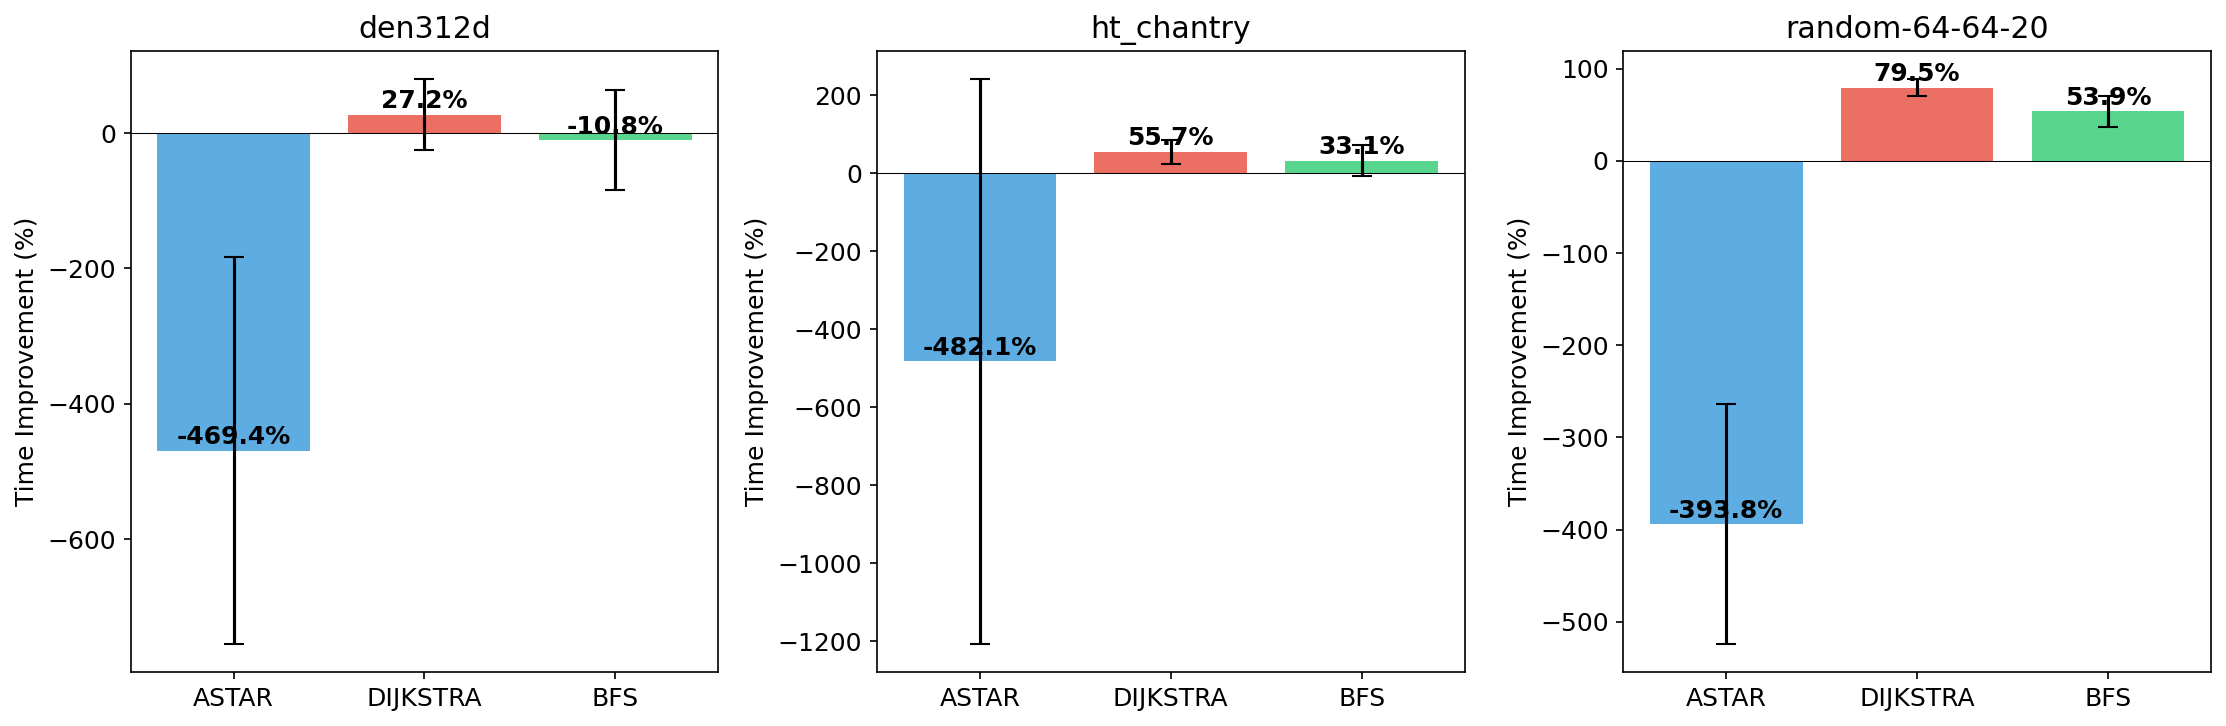

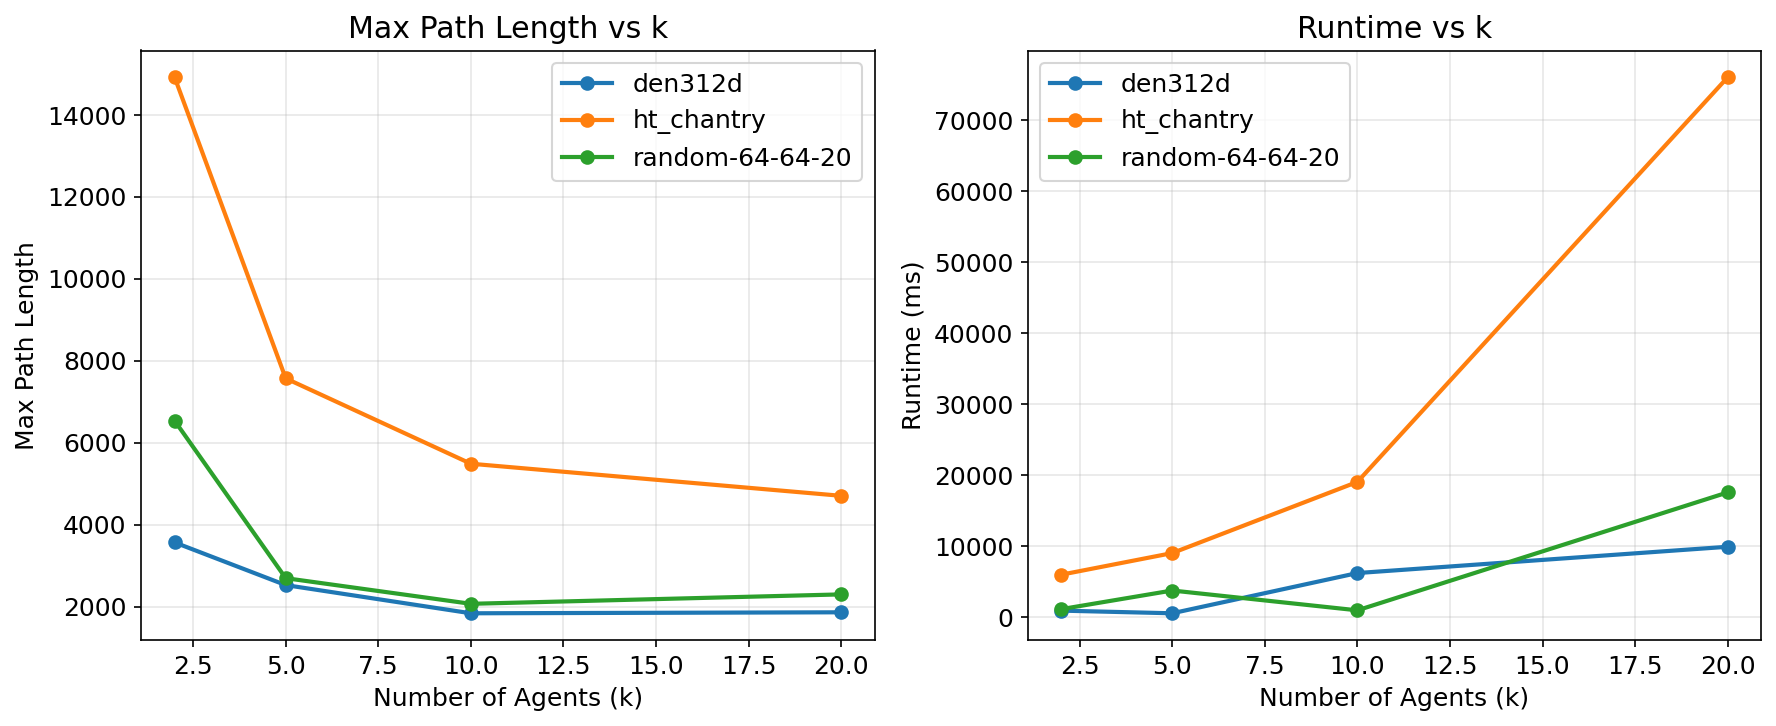

In [11]:
if len(ails_results) > 0:
    # Plot 1: Time improvement by algorithm and map
    fig, axes = plt.subplots(1, len(benchmark_grids), figsize=(5*len(benchmark_grids), 5))
    if len(benchmark_grids) == 1:
        axes = [axes]
    
    for idx, map_name in enumerate(benchmark_grids.keys()):
        ax = axes[idx]
        map_df = ails_results[ails_results['map'] == map_name]
        
        algos = ['astar', 'dijkstra', 'bfs']
        imps = [map_df[map_df['algorithm'] == a]['time_improvement'].mean() for a in algos]
        errs = [map_df[map_df['algorithm'] == a]['time_improvement'].std() for a in algos]
        
        bars = ax.bar(range(3), imps, yerr=errs, capsize=5,
                     color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)
        ax.set_xticks(range(3))
        ax.set_xticklabels([a.upper() for a in algos])
        ax.set_ylabel('Time Improvement (%)')
        ax.set_title(f'{map_name}')
        ax.axhline(0, color='black', linewidth=0.5)
        
        for bar, imp in zip(bars, imps):
            ax.annotate(f'{imp:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords="offset points", ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('ails_time_improvement.png', dpi=300, bbox_inches='tight')
    plt.show()

if len(mcpp_results) > 0:
    # Plot 2: MCPP results (matching Figure 9 in Lee & Lee)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Max path length
    ax = axes[0]
    for map_name in benchmark_grids.keys():
        df = mcpp_results[mcpp_results['map'] == map_name]
        grouped = df.groupby('k')['max_length'].mean()
        ax.plot(grouped.index, grouped.values, 'o-', label=map_name, linewidth=2)
    ax.set_xlabel('Number of Agents (k)')
    ax.set_ylabel('Max Path Length')
    ax.set_title('Max Path Length vs k')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Runtime
    ax = axes[1]
    for map_name in benchmark_grids.keys():
        df = mcpp_results[mcpp_results['map'] == map_name]
        grouped = df.groupby('k')['time'].mean()
        ax.plot(grouped.index, grouped.values, 'o-', label=map_name, linewidth=2)
    ax.set_xlabel('Number of Agents (k)')
    ax.set_ylabel('Runtime (ms)')
    ax.set_title('Runtime vs k')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('mcpp_results.png', dpi=300, bbox_inches='tight')
    plt.show()

## Summary

This notebook replicates the experimental setup from Lee & Lee (2025) using:

**Grid Maps (from Moving AI Lab):**
- den312d (65×81, 2445 vertices)
- ht_chantry (162×141, 7461 vertices)
- random-64-64-20 (64×64, 3270 vertices)

**Road Networks (optional, requires OSMnx):**
- pnu (Pusan National University)
- jangjeon (Jangjeon-dong, Busan)

**To get exact same data:**
1. Download maps from https://www.movingai.com/benchmarks/mapf/
2. For road networks, contact authors or extract from OpenStreetMap

In [12]:
print("\n" + "="*60)
print("FILES GENERATED")
print("="*60)
print("""
Results:
  - ails_results_summary.csv
  - ails_results_full.csv
  - mcpp_results_summary.csv
  - mcpp_results_full.csv

Figures:
  - benchmark_maps.png
  - ails_time_improvement.png
  - mcpp_results.png

To get EXACT same data as Lee & Lee (2025):
  1. Download from: https://www.movingai.com/benchmarks/mapf/
  2. Place .map files in ./benchmark_data/
  3. Re-run this notebook
""")


FILES GENERATED

Results:
  - ails_results_summary.csv
  - ails_results_full.csv
  - mcpp_results_summary.csv
  - mcpp_results_full.csv

Figures:
  - benchmark_maps.png
  - ails_time_improvement.png
  - mcpp_results.png

To get EXACT same data as Lee & Lee (2025):
  1. Download from: https://www.movingai.com/benchmarks/mapf/
  2. Place .map files in ./benchmark_data/
  3. Re-run this notebook

